In [113]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
warnings.simplefilter('ignore')

In [114]:
# Get the service client
s3 = boto3.client('s3')
bucket_name = 'sagemaker-learner'
folder_path = 'data'
data_uri = "s3://sagemaker-learner/data/salary.csv"

try: 
    s3.download_file("sagemaker-learner", "data/salary.csv", "salary.csv")
    print(f"File downloaded")
except:
    prnt(f"Error in file download")

File downloaded


In [120]:
df = pd.read_csv('salary.csv')
df.head()

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


In [121]:
X = df['YearsExperience']
y = df['Salary']

X.shape,y.shape

((35,), (35,))

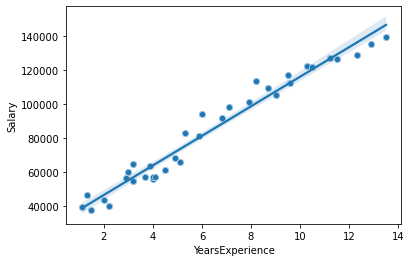

In [122]:
sns.regplot(X,y)
sns.scatterplot(X,y)
plt.show()

### Train test split

In [142]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)




In [143]:
# scalling data berfore linear regerssion
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train.values.reshape(-1,1))

X_train = std.transform(X_train.values.reshape(-1,1))
X_test = std.transform(X_test.values.reshape(-1,1))


## Linear regerssion model using sklearn

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

model = LinearRegression()
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


print(f'Train mse : {mean_squared_error(y_train,y_train_pred)}')
print(f'Test mse : {mean_squared_error(y_test,y_test_pred)}')


print(f'R2 score : {r2_score(y_train,y_train_pred)}')
print(f'R2 score : {r2_score(y_test,y_test_pred)}')

Train mse : 29249963.411905907
Test mse : 54958757.926339835
R2 score : 0.9742750759768667
R2 score : 0.9094204577612955


## Train model using sagemaker

First we will upload data to s3

In [144]:
y_train = y_train.values
y_test = y_test.values

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')


#writing file to s3 location
s3_train_key = 'salary_prediction/train'
s3_test_key = 'salary_prediction/test'

 
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O).
import sagemaker.amazon.common as smac

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker Linear Learner
s3_client = boto3.client('s3') 

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 
s3_client.upload_fileobj(buf, bucket_name, s3_train_key)

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 
s3_client.upload_fileobj(buf, bucket_name, s3_test_key)


In [145]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3

sagemaker_session = sagemaker.Session()
# get region
region_name = boto3.Session().region_name
# get execution role
role =  sagemaker.get_execution_role()


output_location = "s3://sagemaker-learner/salary_prediction/"
container = get_image_uri(region_name, 'linear-learner')
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [146]:
linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 6,
                           loss = 'squared_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model
s3_train_path = "s3://sagemaker-learner/salary_prediction/train"
linear.fit({'train': s3_train_path})


2022-09-05 09:10:49 Starting - Starting the training job...
2022-09-05 09:11:17 Starting - Preparing the instances for trainingProfilerReport-1662369049: InProgress
......
2022-09-05 09:12:20 Downloading - Downloading input data...
2022-09-05 09:12:40 Training - Downloading the training image.............Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/05/2022 09:14:55 INFO 140587301197632] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', '

### Deploying best model

In [148]:

from sagemaker.predictor import csv_serializer, json_deserializer

linear_regressor = linear.deploy(initial_instance_count = 1,
                                instance_type = 'ml.m4.xlarge')




----------!

In [150]:
linear_regressor.__dict__.keys()

dict_keys(['endpoint_name', 'sagemaker_session', 'serializer', 'deserializer', '_endpoint_config_name', '_model_names', '_context'])

In [152]:

linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

# making prediction on the test data

result = linear_regressor.predict(X_test)
result


The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'score': 107335.7890625},
  {'score': 51305.6015625},
  {'score': 99035.0234375},
  {'score': 82433.484375},
  {'score': 59606.37109375},
  {'score': 117711.75},
  {'score': 71019.9296875},
  {'score': 50268.0078125},
  {'score': 41967.2421875}]}

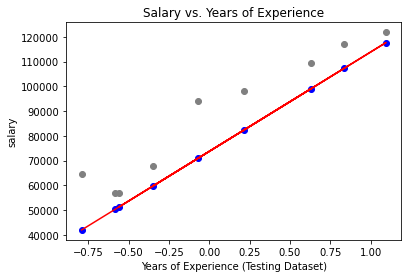

In [156]:
predictions = np.array([r['score'] for r in result['predictions']])
# VISUALIZE TEST SET RESULTS
plt.scatter(X_test, y_test, color = 'gray')
plt.scatter(X_test, predictions, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Years of Experience (Testing Dataset)')
plt.ylabel('salary')
plt.title('Salary vs. Years of Experience')
plt.show()

In [161]:
# Delete the end-point
linear_regressor.delete_endpoint()